# Block-matrix formulation for 1D problem
Equation 
$$\dfrac{d q}{d t} = -\frac{x}{10} \dfrac{d q}{d x} + 10^{-2} \dfrac{d^2 q}{d x^2} + f(x,t) \quad x \in [1,10] , $$
$$f(x,t) = e^{-x^2/.1}\sin(t)$$

Boundary conditions
$$q(x=1,t) = 0 $$
$$\dfrac{\partial q(x=10,t)}{\partial x} = 0 $$

Discretization method: first order in time (explicit) and in space. In order to simplify the code and make it easier to adapt to other problems/other formulations (e.g., implicit methods), we will use a block matrix approach.

## Block matrix approach.
Create a matrix which approximates the spatial derivative operator, $D_x \approx \dfrac{\partial }{\partial x}$, and a diagonal matrix which has the coefficients in front of the derivative operator:
$$ D_x = \frac{1}{\Delta x}\left[ \begin{matrix} 
    -1 & 1 & \cdots & & \\
    -1 & 1 & \cdots & & \\
     0 & -1 & 1 & \cdots & & \\
     0 & 0 & -1 & 1 & \cdots & & \\
    \vdots & \vdots & \vdots &\vdots & \ddots & & \\
    & & & & \cdots & -1 & 1 \\
    & & & & \cdots & -1 & 1 \\
\end{matrix}\right] , 
C = \left[ \begin{matrix} 
    x_1 & 0    & 0 &\cdots  \\
    0   & x_2  & 0 &\cdots  \\
    0   & 0    & x_3  &\cdots  \\
        &      &      &\ddots  
\end{matrix}\right] $$

The semi-discretized equations can thus be writen as
$$ \dfrac{d Q}{d t} = \underbrace{C_1 D_x + C_2 D_{xx} }_A Q + F(t), $$


In [1]:
import numpy as np

deltax = .1
x0 = 1
x1 = 10

x = np.arange(x0,x1,deltax)
nx = len(x)

# Create first order derivative matrix
Dx  = np.zeros((nx,nx))

Dx[0,0] = -1.0/deltax
Dx[0,1] =  1.0/deltax

for i in range(1,nx):
    Dx[i,i]     =  1.0/deltax
    Dx[i,i-1]   = -1.0/deltax

# Create second order derivative matrix
Dxx = np.zeros((nx,nx))

Dxx[0,0] = 1.0/deltax**2
Dxx[0,1] = -2.0/deltax**2
Dxx[0,2] = 1.0/deltax**2

for i in range(1,nx-1):
    Dxx[i,i-1] =  1.0/deltax**2
    Dxx[i,i  ] = -2.0/deltax**2
    Dxx[i,i+1] =  1.0/deltax**2
Dxx[-1,-3] =  1.0/deltax**2
Dxx[-1,-2] = -2.0/deltax**2
Dxx[-1,-1] =  1.0/deltax**2

# Create the constant diagonal matrix
C0 =-np.diag(x)/1
C1 = np.eye(nx)*1e-2


# Create the linear operator
A =  np.matmul(C0,Dx) + np.matmul(C1,Dxx) 
# A =  np.matmul(C1,Dxx) 



# Boundary conditions
## Dirichlet : Impose $q(x=1,t)=0$.
Imposing this condition, the vector 
$$ Q = \left[ \begin{matrix} 
    q_1 \\ q_2 \\ q_3 \\ \vdots
\end{matrix}\right] $$
becomes 
$$ \left[ \begin{matrix} 
    0 \\ q_2 \\ q_3 \\ \vdots
\end{matrix}\right]  
=  \left[ \begin{matrix} 
    0 \\ \tilde{Q}
\end{matrix}\right]   $$

The problem, with the boundary conditions can thus be re-writen as 
$$ \dfrac{d \tilde{Q}}{dt} = \tilde{A}\tilde{Q} + \tilde{F} $$
where $\tilde{F}$ is $F$ with the first entry removed, and $\tilde{A}$ is $A$ with the first line and row removed.

## Neumann Conditions : $\dfrac{\partial q}{\partial x}(x=10,t)$ = 0
To impose this boundary condition we will perform a change in the DOFs of the problem:
$$Q = \left[ \begin{matrix} 
    q_1 \\ \vdots \\ q_{n-1} \\ q_{n}
\end{matrix}\right] \to  
\tilde{Q} = \left[ \begin{matrix} 
    q_1 \\ \vdots \\ q_{n-1} \\ \frac{\partial q_{n}}{\partial x}
\end{matrix}\right] 
$$

This is obtained as
$$\tilde{Q} = \underbrace{\left[ \begin{matrix} 
    1 & 0 & \cdots \\ 
    0  & 1 & \cdots \\
    \vdots & \vdots \\ \ddots \\
     - & D_x[end,:] & -
\end{matrix}\right]}_T Q $$

Multiplying the equation by $T$, we can re-write it as
$$ \dfrac{d \tilde{Q}}{dt} = T A T^{-1} T Q + T F = \tilde{A} \tilde{Q} + \tilde{F} $$  

We can then impose the b.c. as before: removing the last line and column of the matrix.

In [2]:
T = np.eye(nx)
T[-1,:] = Dx[-1,:]
Ti = np.linalg.inv(T)

At = np.matmul(T ,A )
At = np.matmul(At, Ti )


Abc = At[1:-1,1:-1] # Apply boundary conditions


## Explicit time-stepping
$$ Q^{n+1}  = (I + \Delta t A) Q^n + F^n$$


In [3]:
deltat = 1e-3
Ttotal = 20
nt = round(Ttotal/deltat)
t = np.arange(0,nt*deltat,deltat)
Q0  = (x-1)*(x-10)**2*0
Qt  = Q0[1:-1] # remove dofs at the boundaries
Qt  = Qt.reshape((nx-2,1))

I = np.eye(nx-2) # as now Q has nx-2 elements
QQt = np.zeros((nx-2,nt)) # matrix to store the solution
QQt[:,0] = Qt[:,0] # store the initial condition
for i in range(1,nt):
    # print(i)
    F = np.exp(-(x-2)**2/.1)*np.sin(deltat*(i-1))
    F = F[1:-1]
    F = F.reshape((nx-2,1))
    Qt = np.matmul( I + deltat * Abc , Qt) + deltat*F
    QQt[:,i] = Qt[:,0]


# Plot solutions


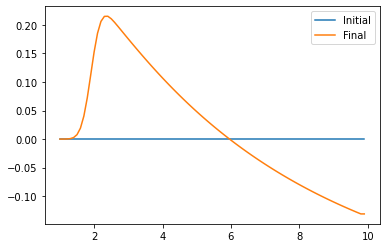

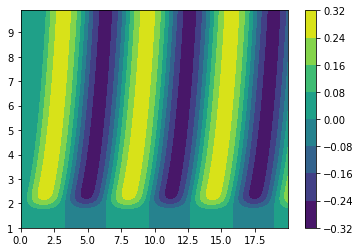

In [4]:
import matplotlib.pyplot as plt

# Reconstruct Q from Qt
## Add the boundary conditions
QQ =  np.concatenate((np.zeros((1,nt)),QQt,np.zeros((1,nt))),axis=0)
QQ = np.matmul(Ti , QQ)


plt.plot(x,QQ[:,0])
plt.plot(x,QQ[:,-1])
plt.legend(['Initial','Final'])

plt.figure()
plt.contourf(t,x,QQ)
plt.colorbar()